In [1]:
# !pip install IPython
from IPython.display import Image

In [ ]:
!git clone https://github.com/Im-JihyunKim/2023_LG_ES_SSL_1.git # colab 사용시

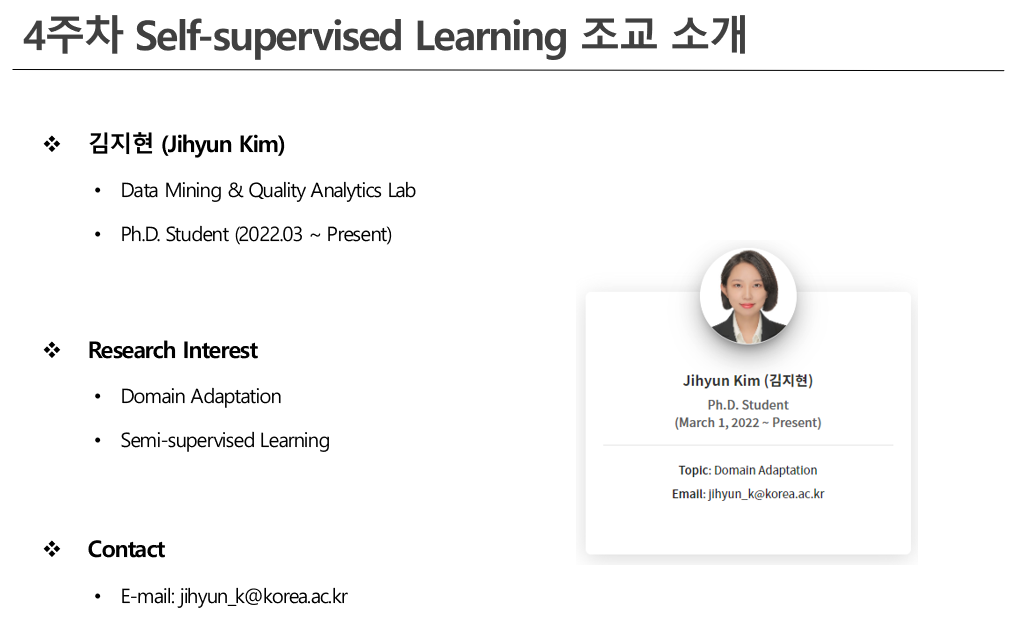

In [4]:
# Image('image/image1.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/image1.PNG') # colab 사용시

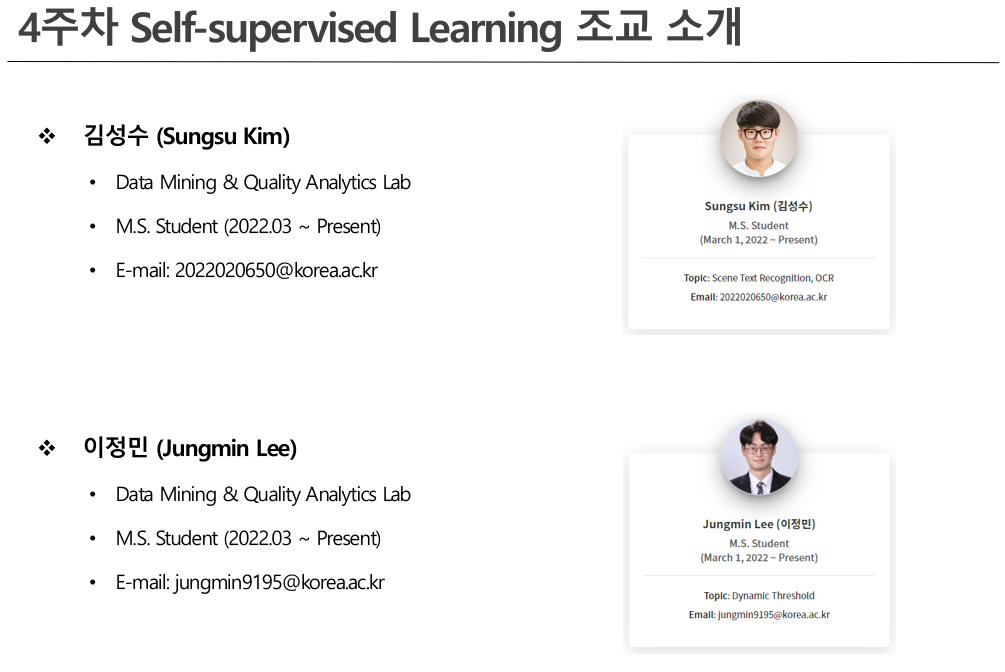

In [5]:
# Image('image/image2.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/image2.PNG') # colab 사용시

----

# [Self-supervised Learning] SimCLR

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 모듈 불러오기

In [2]:
import os, random
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader, Subset  # Dataset과 dataloader를 기반으로 미니배치 학습, 데이터 셔플, 병렬 처리까지 간단하게 수행 가능하도록 지원
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\JihyunKim\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [3]:
'''
seed 정의
https://hoya012.github.io/blog/reproducible_pytorch/
'''
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 2. Custom Dataset 정의
- 방대한 데이터를 batch 단위로 쪼개서 불러올 수 있도록 정의해주는 과정 (기존에는 모든 데이터셋을 한꺼번에 처리)
- Custom Dataset은 가변 길이 input이나 batch를 만들어줄 때 필요  
- 본 튜토리얼에서는 증강된 이미지도 함께 불러와야 하기에 이를 가져올 수 있는 Custom Dataset을 정의할 것임  
cf. https://didu-story.tistory.com/85

### CIFAR10 Dataset

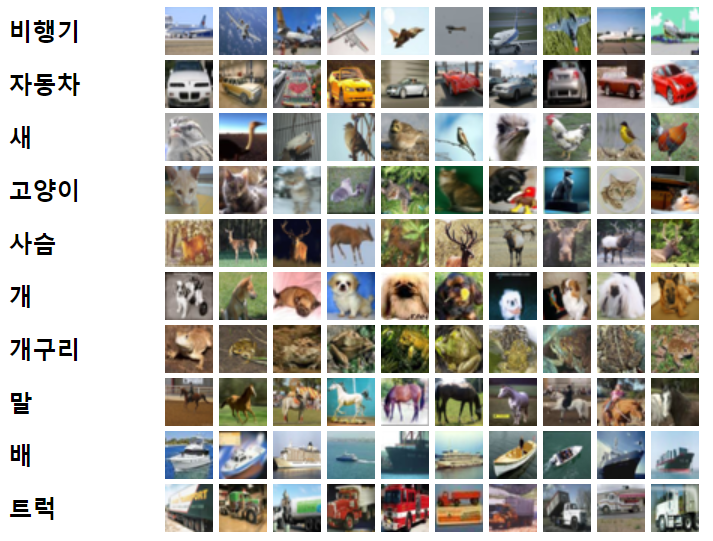

In [9]:
# Image('image/cifar10.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/cifar10.PNG') # colab 사용시

- 32x32의 RGB 이미지로 구성된 데이터셋
  - 총 60,000개의 데이터가 있으며 일반적으로 50,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 50,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 따로 지정하지 않음)
- 10개의 class를 분류하는 image classification task에 주로 활용

### SimCLR Augmentation

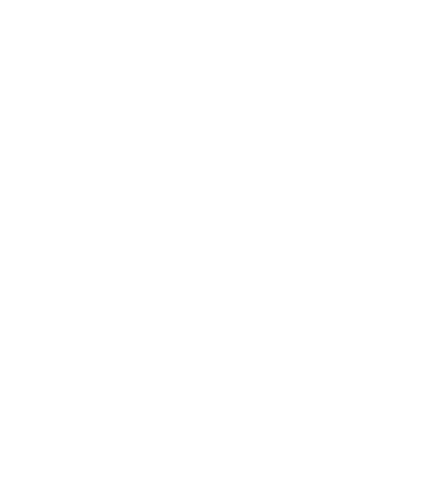

In [30]:
# Image('image/SimCLR_train.gif') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/SimCLR_train.gif') # colab 사용시

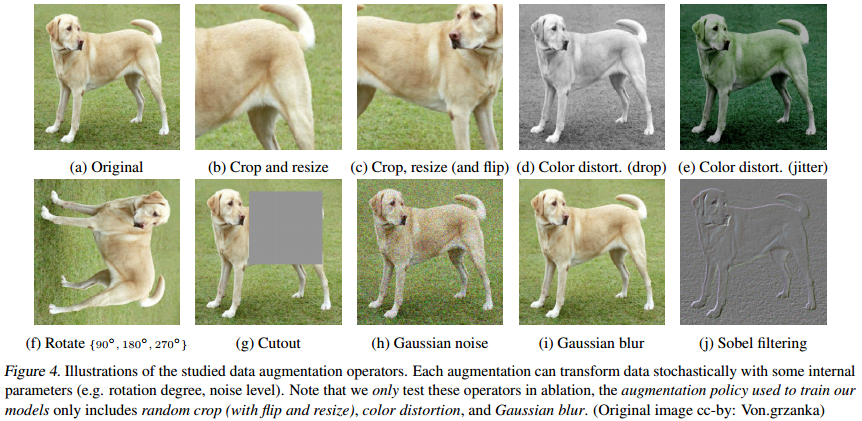

In [10]:
# Image('image/SimCLR_aug.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/SimCLR_aug.PNG') # colab 사용시

In [6]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data_dir:str):
        self.data_dir = data_dir

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(data_dir, exist_ok=True)


    # For SimCLR : SimCLR 사전학습 시 사용되는 데이터셋
    def get_pretrain_dataset(self, n_views: int=2):
        pretrain_dataset = datasets.CIFAR10(self.data_dir, 
                                            train=True,  # train 여부
                                            transform=ViewGenerator(   # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                    base_transform=self.get_transform(size=32),  # 사전에 정의한 이미지 변형 방법 적용
                                                    n_views=n_views),  # view는 하나의 동일한 이미지를 다른 시각으로 본다는 의미로, number of views 만큼 augmentation 수행
                                            download=True)
        return pretrain_dataset
    
    # For Downstream task : Downstream 지도학습에 사용되는 데이터
    def get_dataset(self, mode: str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), test_size=0.2, random_state=2023)

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        

    @staticmethod  # 해당 클래스에서만 사용되는 메소드
    def get_transform(size: int=96, s:int=1):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        - SImCLR에서는 augmentation에 대해서 'random crop and resize', 'color distortion', 'blur'가 결합된 augmentation이 좋은 성능을 도출한다고 설명
        """
        normalize = transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010)
        )
        color_jitter = transforms.ColorJitter(0.8 * s, 
                                              0.8 * s,
                                              0.8 * s,
                                              0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms
    

########################################################################################################################################

class ViewGenerator(object):
    """
    Take 2 ransom crops of one image as the query and key.
    """
    def __init__(self, base_transform, n_views: int=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):  # ViewGenerator 클래스 호출 시 수행되는 함수
        return [self.base_transform(x) for i in range(self.n_views)]  # n_views 만큼 base_transform(get_transform 메소드에서 정의된 증강기법)을 수행하라

### CIFAR 10 Augmented examples 확인

Files already downloaded and verified


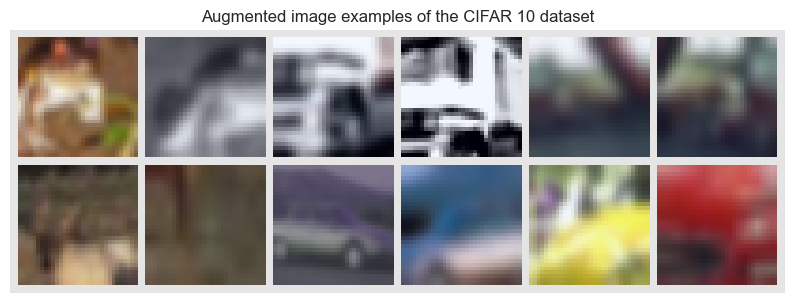

In [7]:
# data_dir = './data/'
data_dir = '/content/2023_LG_ES_SSL_1/data/'   # colab 사용 시

# load dataset
Cifar10 = CIFAR10Dataset(data_dir)
Cifar10_dataset = Cifar10.get_pretrain_dataset()

# call imgs
imgs = torch.stack([img for idx in range(6) for img in Cifar10_dataset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

# visualization
plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the CIFAR 10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### cf. CIFAR 10 원본 이미지

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


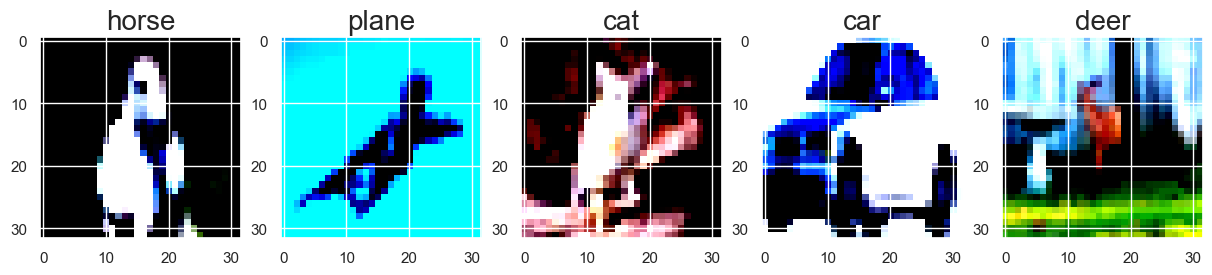

In [8]:
Cifar10_origin = Cifar10.get_dataset()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = DataLoader(
        dataset=Cifar10_origin,
        batch_size=5,
        shuffle=True,
        num_workers=0,
        drop_last=False)
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## 3. SimCLR 네트워크 정의

- Backbone : ResNet
- Classifier : MLP

In [13]:
class ResNet(nn.Module):
    def __init__(self, base_model: str, hidden_size: int, projection_size: int):
        super(ResNet, self).__init__()

        self.resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   # ResNet layer 개수에 따라 다른 backbone 선정
            'resnet50': models.resnet50(pretrained=False)
        }

        resnet = self.get_basemodel(base_model)

        # Define CNN encoder
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1])
        
        # Define MLP Projection
        self.projection = MLPHead(in_channels=resnet.fc.in_features,
                                  mlp_hidden_size=hidden_size,
                                  projection_size=projection_size)
        
    def forward(self, x: torch.Tensor):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        
        return self.projection(h)
    
    def get_basemodel(self, model_name: str = None):
        
        model = self.resnet_dict[model_name]
        
        return model
    

######################################################################################################

class MLPHead(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size):
        super(MLPHead, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size), 
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

## 4. SimCLR 학습 정의

### SimCLR 모델 평가지표
- accuracy, info_NCE loss

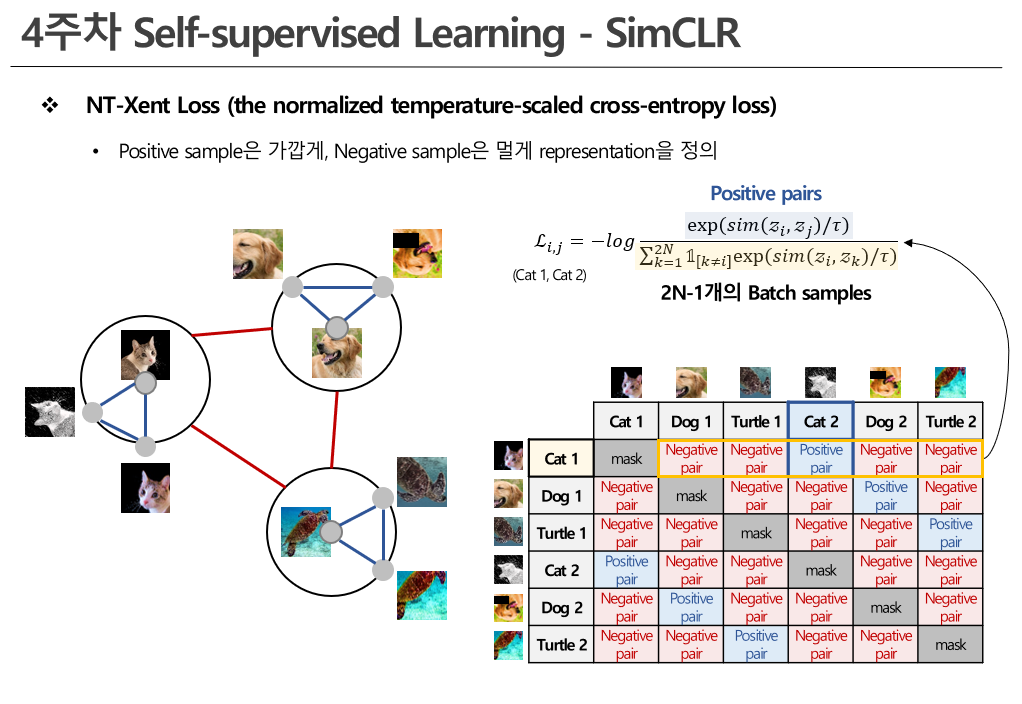

In [29]:
# Image('image/InfoNCE1.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/InfoNCE1.PNG') # colab 사용시

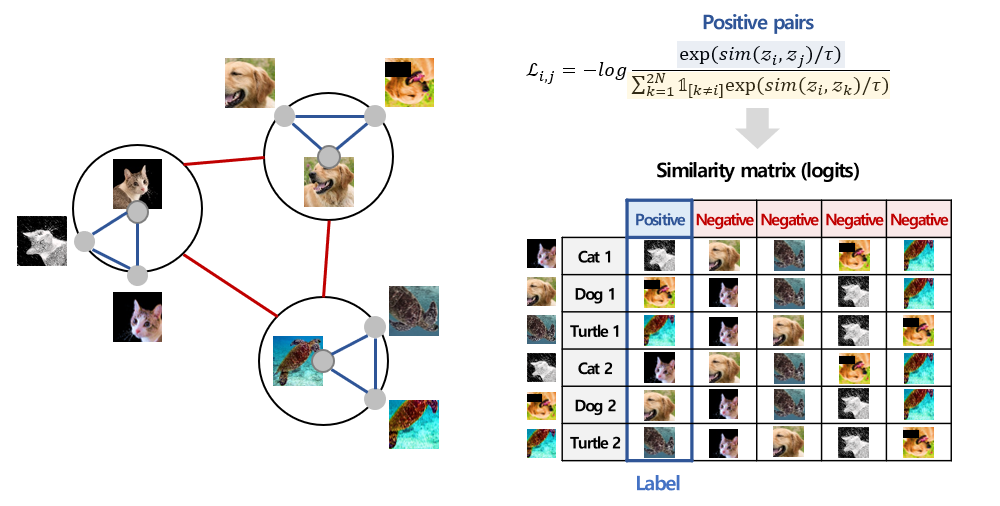

In [30]:
# Image('image/InfoNCE2.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/InfoNCE2.PNG') # colab 사용시

In [9]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    """
    Computes the accuracy over the top k predictions
    for the specified values of k
    - Top-1 Accuracy: softmax의 output에서 제일 높은 수치(confidence)를 가지는 확률 값이 실제 정답일 경우에 대한 지표 계산
    - Top-n Accuracy : softmax output 중 상위 n개의 확률 값을 가지는 클래스 중 실제 정답이 있는 경우에 대한 지표 계산
    """
    with torch.no_grad():
        max_k = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

### SimCLR 모델/Trainer 정의

In [10]:
class SimCLR_Trainer(object):
    def __init__(self, device, model, **kwargs):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.__dict__.update(kwargs)

    def info_nce(self, features: torch.FloatTensor, n_views: int=2):
        # 0, 1, ..., batch_size -> positive, negative에 대한 label
        labels = torch.cat([torch.arange(self.batch_size) for i in range(n_views)], dim=0)

        # 동일한 값 기준으로 0, 1 행렬 표현
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        # Normalize Feature Vector
        features = F.normalize(features, dim=1)

        # 정규화된 벡터 간 행렬 곱 (similarity 구하기)
        similarity_matrix = torch.matmul(features, features.T)

        # labels matrix, similarity matrix에서 main diagonal 지우기
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # Select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # Select only the negatives
        negatives = similarity_matrix[~labels.bool()].view(labels.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)   # scaling된 logits 값 도출
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)  # positive (0번째 index)만 label

        logits = logits / self.tau

        return logits, labels
    
    def pretrain(self, train_loader):

        n_iter = 0
        for epoch in range(self.epochs):
            train_loss = 0
            for images, _ in tqdm(train_loader):
                images = torch.cat(images, dim=0)  # 2 * Batch Size (2는 n_views, 즉 augmentation 횟수)
                images = images.to(self.device)

                features = self.model(images)
                logits, labels = self.info_nce(features=features)
                loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss

                if n_iter % self.logging_steps == 0:
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    print(f'Loss: {loss} \n'
                          f'ACC/Top1: {top1[0]} \n'
                          f'ACC/Top5: {top5[0]} \n'
                          f'Learning Rate: {self.lr_scheduler.get_lr()[0]}')
                
                n_iter += 1
            
            train_loss /= (len(train_loader))

            # Warmup for the first 10 epochs
            if epoch >= 10:
                self.lr_scheduler.step()
            
            print('=' * 30)
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Accuracy: {top1[0]} \n'
                  f'Top5 Accuracy: {top5[0]} \n'
                  f'Learning Rate: {self.lr_scheduler.get_lr()[0]}')
            
        return self.model

### (참고) Learning rate scheduler
- 모델의 학습 속도를 일정한 값을 그대로 사용하는 대신, 학습 중 learning rate을 조절해주는 기법
- SimCLR은 `Cosine Annealing lr scheduler`를 사용
  - 참고문헌 [SGDR: Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.03983)
- Cosine Annealing은 learning rate가 cosine 함수의 주기를 따라 감소하고 증가하는 과정을 반복하도록 함

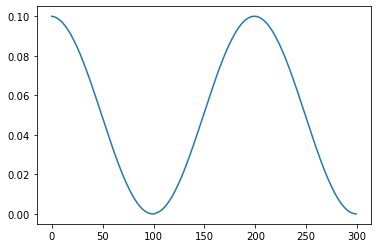

In [37]:
# Image('image/lr_cosine.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/lr_cosine.PNG') # colab 사용시

### 학습에 필요한 hyperparameters 정의

## SimCLR 코드 실행

In [14]:
def main(device, configs: dict):

    # define dataset, dataloader
    dataset = CIFAR10Dataset(data_dir=configs['data_dir'])   # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'

    train_dataset = dataset.get_pretrain_dataset(n_views=configs['n_views'])
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)

    # definde model, optimizer, learning rate scheduler
    model = ResNet(
        base_model=configs['backbone'],
        hidden_size=configs['hidden_size'],
        projection_size=configs['projection_size']
    )

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(   # cosine annealing scheduler
        optimizer=optimizer,
        T_max=len(train_loader),
        eta_min=0,
        last_epoch=-1)

    trainer = SimCLR_Trainer(
        model=model,
        device=device,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        batch_size = configs['batch_size'],
        tau = configs['tau'],
        epochs = configs['epochs'],
        logging_steps = configs['logging_steps']
        )
        
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    configs = {'data_dir': './data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'batch_size': 256, 'epochs': 5, 'tau': 0.07, 'logging_steps': 20, 
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'n_views':2, 'num_worker': 0}
    
    pretrained_model = main(device, configs)

Files already downloaded and verified


  1%|          | 1/195 [00:03<12:06,  3.74s/it]

Loss: 6.700517654418945 
ACC/Top1: 1.953125 
ACC/Top5: 5.078125 
Learning Rate: 0.0003


 11%|█         | 21/195 [00:18<02:10,  1.33it/s]

Loss: 6.024184703826904 
ACC/Top1: 0.390625 
ACC/Top5: 4.8828125 
Learning Rate: 0.0003


 21%|██        | 41/195 [00:33<01:56,  1.32it/s]

Loss: 5.945589065551758 
ACC/Top1: 0.5859375 
ACC/Top5: 4.1015625 
Learning Rate: 0.0003


 31%|███▏      | 61/195 [00:48<01:49,  1.23it/s]

Loss: 5.8503546714782715 
ACC/Top1: 2.734375 
ACC/Top5: 7.03125 
Learning Rate: 0.0003


 42%|████▏     | 81/195 [01:04<01:27,  1.30it/s]

Loss: 5.748055458068848 
ACC/Top1: 3.7109375 
ACC/Top5: 10.7421875 
Learning Rate: 0.0003


 52%|█████▏    | 101/195 [01:19<01:11,  1.32it/s]

Loss: 5.772597312927246 
ACC/Top1: 2.5390625 
ACC/Top5: 7.6171875 
Learning Rate: 0.0003


 62%|██████▏   | 121/195 [01:34<00:54,  1.37it/s]

Loss: 5.707597255706787 
ACC/Top1: 3.125 
ACC/Top5: 9.375 
Learning Rate: 0.0003


 72%|███████▏  | 141/195 [01:49<00:42,  1.26it/s]

Loss: 5.720990180969238 
ACC/Top1: 2.9296875 
ACC/Top5: 10.3515625 
Learning Rate: 0.0003


 83%|████████▎ | 161/195 [02:04<00:25,  1.35it/s]

Loss: 5.515013694763184 
ACC/Top1: 4.296875 
ACC/Top5: 13.4765625 
Learning Rate: 0.0003


 93%|█████████▎| 181/195 [02:19<00:11,  1.24it/s]

Loss: 5.630130767822266 
ACC/Top1: 3.90625 
ACC/Top5: 12.890625 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:30<00:00,  1.30it/s]


Epoch: 1 
Loss: 5.766052722930908 
Top1 Accuracy: 3.90625 
Top5 Accuracy: 12.890625 
Learning Rate: 0.0003


  3%|▎         | 6/195 [00:04<02:24,  1.31it/s]

Loss: 5.614169597625732 
ACC/Top1: 5.46875 
ACC/Top5: 11.5234375 
Learning Rate: 0.0003


 13%|█▎        | 26/195 [00:19<02:11,  1.29it/s]

Loss: 5.414807319641113 
ACC/Top1: 4.296875 
ACC/Top5: 14.84375 
Learning Rate: 0.0003


 24%|██▎       | 46/195 [00:35<01:51,  1.33it/s]

Loss: 5.4882988929748535 
ACC/Top1: 2.5390625 
ACC/Top5: 10.7421875 
Learning Rate: 0.0003


 34%|███▍      | 66/195 [00:50<01:36,  1.34it/s]

Loss: 5.476283073425293 
ACC/Top1: 5.078125 
ACC/Top5: 13.0859375 
Learning Rate: 0.0003


 44%|████▍     | 86/195 [01:05<01:22,  1.31it/s]

Loss: 5.454056739807129 
ACC/Top1: 4.6875 
ACC/Top5: 15.0390625 
Learning Rate: 0.0003


 54%|█████▍    | 106/195 [01:20<01:10,  1.26it/s]

Loss: 5.460229873657227 
ACC/Top1: 7.03125 
ACC/Top5: 17.7734375 
Learning Rate: 0.0003


 65%|██████▍   | 126/195 [01:35<00:51,  1.34it/s]

Loss: 5.304483413696289 
ACC/Top1: 4.6875 
ACC/Top5: 16.796875 
Learning Rate: 0.0003


 75%|███████▍  | 146/195 [01:50<00:36,  1.34it/s]

Loss: 5.38978910446167 
ACC/Top1: 3.515625 
ACC/Top5: 16.9921875 
Learning Rate: 0.0003


 85%|████████▌ | 166/195 [02:05<00:22,  1.26it/s]

Loss: 5.288825988769531 
ACC/Top1: 7.421875 
ACC/Top5: 24.21875 
Learning Rate: 0.0003


 95%|█████████▌| 186/195 [02:20<00:06,  1.32it/s]

Loss: 5.37226676940918 
ACC/Top1: 7.421875 
ACC/Top5: 17.1875 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:27<00:00,  1.32it/s]


Epoch: 2 
Loss: 5.4145379066467285 
Top1 Accuracy: 7.421875 
Top5 Accuracy: 17.1875 
Learning Rate: 0.0003


  6%|▌         | 11/195 [00:08<02:18,  1.33it/s]

Loss: 5.312193870544434 
ACC/Top1: 7.8125 
ACC/Top5: 19.7265625 
Learning Rate: 0.0003


 16%|█▌        | 31/195 [00:23<02:09,  1.27it/s]

Loss: 5.077909469604492 
ACC/Top1: 9.375 
ACC/Top5: 24.4140625 
Learning Rate: 0.0003


 26%|██▌       | 51/195 [00:38<01:50,  1.30it/s]

Loss: 5.043144226074219 
ACC/Top1: 9.5703125 
ACC/Top5: 24.609375 
Learning Rate: 0.0003


 36%|███▋      | 71/195 [00:53<01:37,  1.27it/s]

Loss: 5.296085834503174 
ACC/Top1: 8.984375 
ACC/Top5: 20.5078125 
Learning Rate: 0.0003


 47%|████▋     | 91/195 [01:08<01:15,  1.38it/s]

Loss: 5.113143444061279 
ACC/Top1: 12.109375 
ACC/Top5: 25.9765625 
Learning Rate: 0.0003


 57%|█████▋    | 111/195 [01:23<01:02,  1.34it/s]

Loss: 5.253668308258057 
ACC/Top1: 9.375 
ACC/Top5: 19.3359375 
Learning Rate: 0.0003


 67%|██████▋   | 131/195 [01:37<00:48,  1.32it/s]

Loss: 4.997411727905273 
ACC/Top1: 13.8671875 
ACC/Top5: 26.3671875 
Learning Rate: 0.0003


 77%|███████▋  | 151/195 [01:52<00:36,  1.22it/s]

Loss: 4.9820966720581055 
ACC/Top1: 10.546875 
ACC/Top5: 24.8046875 
Learning Rate: 0.0003


 88%|████████▊ | 171/195 [02:07<00:18,  1.33it/s]

Loss: 5.098470211029053 
ACC/Top1: 13.28125 
ACC/Top5: 23.828125 
Learning Rate: 0.0003


 98%|█████████▊| 191/195 [02:23<00:03,  1.20it/s]

Loss: 4.868042469024658 
ACC/Top1: 13.671875 
ACC/Top5: 29.296875 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:26<00:00,  1.33it/s]


Epoch: 3 
Loss: 5.1255292892456055 
Top1 Accuracy: 13.671875 
Top5 Accuracy: 29.296875 
Learning Rate: 0.0003


  8%|▊         | 16/195 [00:12<02:16,  1.31it/s]

Loss: 4.94637393951416 
ACC/Top1: 14.84375 
ACC/Top5: 26.171875 
Learning Rate: 0.0003


 18%|█▊        | 36/195 [00:27<01:59,  1.33it/s]

Loss: 5.104153633117676 
ACC/Top1: 11.5234375 
ACC/Top5: 22.4609375 
Learning Rate: 0.0003


 29%|██▊       | 56/195 [00:42<01:42,  1.36it/s]

Loss: 4.940975666046143 
ACC/Top1: 9.5703125 
ACC/Top5: 23.6328125 
Learning Rate: 0.0003


 39%|███▉      | 76/195 [00:56<01:29,  1.32it/s]

Loss: 5.126161575317383 
ACC/Top1: 10.3515625 
ACC/Top5: 22.4609375 
Learning Rate: 0.0003


 49%|████▉     | 96/195 [01:11<01:13,  1.35it/s]

Loss: 4.99493932723999 
ACC/Top1: 9.5703125 
ACC/Top5: 24.8046875 
Learning Rate: 0.0003


 59%|█████▉    | 116/195 [01:26<00:58,  1.35it/s]

Loss: 4.863950729370117 
ACC/Top1: 13.8671875 
ACC/Top5: 33.203125 
Learning Rate: 0.0003


 70%|██████▉   | 136/195 [01:41<00:43,  1.37it/s]

Loss: 4.795732498168945 
ACC/Top1: 14.6484375 
ACC/Top5: 30.859375 
Learning Rate: 0.0003


 80%|████████  | 156/195 [01:56<00:28,  1.37it/s]

Loss: 4.712952136993408 
ACC/Top1: 12.6953125 
ACC/Top5: 29.8828125 
Learning Rate: 0.0003


 90%|█████████ | 176/195 [02:11<00:14,  1.27it/s]

Loss: 4.882813453674316 
ACC/Top1: 13.0859375 
ACC/Top5: 28.125 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:25<00:00,  1.34it/s]


Epoch: 4 
Loss: 4.904606342315674 
Top1 Accuracy: 13.0859375 
Top5 Accuracy: 28.125 
Learning Rate: 0.0003


  1%|          | 1/195 [00:00<02:28,  1.31it/s]

Loss: 4.776946067810059 
ACC/Top1: 16.015625 
ACC/Top5: 30.2734375 
Learning Rate: 0.0003


 11%|█         | 21/195 [00:15<02:06,  1.37it/s]

Loss: 4.76536750793457 
ACC/Top1: 16.2109375 
ACC/Top5: 31.0546875 
Learning Rate: 0.0003


 21%|██        | 41/195 [00:30<02:00,  1.28it/s]

Loss: 4.7630743980407715 
ACC/Top1: 15.0390625 
ACC/Top5: 33.203125 
Learning Rate: 0.0003


 31%|███▏      | 61/195 [00:45<01:39,  1.35it/s]

Loss: 4.738940715789795 
ACC/Top1: 14.84375 
ACC/Top5: 29.296875 
Learning Rate: 0.0003


 42%|████▏     | 81/195 [00:59<01:24,  1.36it/s]

Loss: 4.838782787322998 
ACC/Top1: 15.4296875 
ACC/Top5: 31.25 
Learning Rate: 0.0003


 52%|█████▏    | 101/195 [01:14<01:08,  1.38it/s]

Loss: 4.7988128662109375 
ACC/Top1: 13.8671875 
ACC/Top5: 27.9296875 
Learning Rate: 0.0003


 62%|██████▏   | 121/195 [01:29<00:55,  1.34it/s]

Loss: 4.580188751220703 
ACC/Top1: 15.234375 
ACC/Top5: 34.5703125 
Learning Rate: 0.0003


 72%|███████▏  | 141/195 [01:44<00:41,  1.31it/s]

Loss: 4.823506832122803 
ACC/Top1: 11.71875 
ACC/Top5: 28.90625 
Learning Rate: 0.0003


 83%|████████▎ | 161/195 [01:58<00:24,  1.37it/s]

Loss: 4.7555108070373535 
ACC/Top1: 18.9453125 
ACC/Top5: 32.421875 
Learning Rate: 0.0003


 93%|█████████▎| 181/195 [02:13<00:10,  1.33it/s]

Loss: 4.591647624969482 
ACC/Top1: 17.96875 
ACC/Top5: 33.3984375 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:23<00:00,  1.35it/s]

Epoch: 5 
Loss: 4.707823276519775 
Top1 Accuracy: 17.96875 
Top5 Accuracy: 33.3984375 
Learning Rate: 0.0003


## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [15]:
class Downstream(object):
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device

        self.encoder = encoder.to(device)   # 사전학습 된 encoder 불러오기
        self.classifier = classifier.to(device)
        self.optimizer = optimizer

        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                # Freeze Encoder Parameters (사전학습된 인코더의 파라미터는 업데이트 하지 않음)
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)


            # Test
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
        
        return self.encoder, self.classifier

In [18]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader   
    Cifar10_dataset = CIFAR10Dataset(data_dir=configs['data_dir'])  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = pretrained_model.encoder
    
    classifier = nn.Linear(512, configs['num_class'])

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'batch_size': 256, 'epochs': 10, 
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 
Loss: 2.1425418853759766 
Top1 Train Accuracy: 23.03466796875 
Top1 Test Accuracy: 36.31310272216797 
Top5 Test Accuracy: 82.95146942138672 

Epoch: 2 
Loss: 1.7413259744644165 
Top1 Train Accuracy: 38.02490234375 
Top1 Test Accuracy: 40.50480651855469 
Top5 Test Accuracy: 86.35816955566406 

Epoch: 3 
Loss: 1.6482441425323486 
Top1 Train Accuracy: 40.673828125 
Top1 Test Accuracy: 41.50390625 
Top5 Test Accuracy: 88.00330352783203 

Epoch: 4 
Loss: 1.6086974143981934 
Top1 Train Accuracy: 41.85791015625 
Top1 Test Accuracy: 41.96589660644531 
Top5 Test Accuracy: 89.34420013427734 

Epoch: 5 
Loss: 1.5782513618469238 
Top1 Train Accuracy: 42.88330078125 
Top1 Test Accuracy: 42.863582611083984 
Top5 Test Accuracy: 89.88882446289062 

Epoch: 6 
Loss: 1.5604110956192017 
Top1 Train Accuracy: 43.85986328125 
Top1 Test Accuracy: 43.53590774536133 
Top5 Test Accuracy: 89.65970611572266 

Epoch: 7 
Loss: 1.5

-----

## [비교] SimCLR로 사전학습을 수행하지 않고, 단순히 지도학습(Supervised Learning)만 적용한 경우

In [21]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader   
    Cifar10_dataset = CIFAR10Dataset(data_dir=configs['data_dir'])  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = ResNet(
        base_model=configs['backbone'],
        hidden_size=configs['hidden_size'],
        projection_size=configs['projection_size']
    ).encoder
    
    classifier = nn.Linear(512, configs['num_class'])

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'batch_size': 256, 'epochs': 10,
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 
Loss: 2.3689663410186768 
Top1 Train Accuracy: 12.68310546875 
Top1 Test Accuracy: 16.075721740722656 
Top5 Test Accuracy: 61.00135040283203 

Epoch: 2 
Loss: 2.238274097442627 
Top1 Train Accuracy: 17.51708984375 
Top1 Test Accuracy: 19.11808967590332 
Top5 Test Accuracy: 66.845703125 

Epoch: 3 
Loss: 2.1635701656341553 
Top1 Train Accuracy: 20.52001953125 
Top1 Test Accuracy: 21.304086685180664 
Top5 Test Accuracy: 70.15474700927734 

Epoch: 4 
Loss: 2.1036972999572754 
Top1 Train Accuracy: 23.40087890625 
Top1 Test Accuracy: 23.275991439819336 
Top5 Test Accuracy: 71.50691223144531 

Epoch: 5 
Loss: 2.0545883178710938 
Top1 Train Accuracy: 25.5859375 
Top1 Test Accuracy: 24.496694564819336 
Top5 Test Accuracy: 72.43464660644531 

Epoch: 6 
Loss: 2.0261001586914062 
Top1 Train Accuracy: 26.8310546875 
Top1 Test Accuracy: 25.796274185180664 
Top5 Test Accuracy: 73.74925231933594 

Epoch: 7 
Loss: 1.